**VGG-19 pretrained model for Event Recognition using PyTorch**

This code is adapted from an Image Classification Project available at  : https://www.najeebhassan.com/ImageClassifierProject.html

In [0]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import os, random
import json
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import time

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/widerdata/images')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
data_dir = '/content/drive/My Drive/'
train_dir = data_dir + 'widerdata/images'
valid_dir = data_dir + 'Validation/images'
test_dir = data_dir + 'prediction2/images'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

cost_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                     ])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
cost_data = datasets.ImageFolder(valid_dir, transform=cost_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=test_transforms)

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(cost_data, batch_size=32)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=32)

image_datasets = [train_data, cost_data, test_data]
dataloaders = [train_loader, valid_loader, test_loader]

In [0]:
import json

with open('/content/drive/My Drive/hellos.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print("\n Length:", len(cat_to_name))

{'0': 'Parade', '1': 'Handshaking', '2': 'Demonstration', '3': 'Riot', '4': 'Cheering', '5': 'Shoppers', '6': 'Soccer'}

 Length: 7


In [0]:
with open('/content/drive/My Drive/hellos.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# TODO: Build and train your network
# Load a pre-trained network
model = models.vgg19(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 93394670.40it/s]


In [0]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout.# Defin 
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('drop', nn.Dropout(p=0.5)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features.
# Track the loss and accuracy on the validation set to determine the best hyperparameters.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

epochs = 10
steps = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
running_loss = 0
accuracy = 0

start = time.time()
print('Training started')

for e in range(epochs):
    
    train_mode = 0
    valid_mode = 1
    
    for mode in [train_mode, valid_mode]:   
        if mode == train_mode:
            model.train()
        else:
            model.eval()
            
        pass_count = 0
        
        for data in dataloaders[mode]:
            pass_count += 1
            inputs, labels = data
            if cuda == True:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            # Forward
            output = model.forward(inputs)
            loss = criterion(output, labels)
            # Backward
            if mode == train_mode:
                loss.backward()
                optimizer.step()                

            running_loss += loss.item()
            ps = torch.exp(output).data
            equality = (labels.data == ps.max(1)[1])
            accuracy = equality.type_as(torch.cuda.FloatTensor()).mean()

        if mode == train_mode:
            print("\nEpoch: {}/{} ".format(e+1, epochs),
                  "\nTraining Loss: {:.4f}  ".format(running_loss/pass_count))
        else:
            print("Validation Loss: {:.4f}  ".format(running_loss/pass_count),
              "Accuracy: {:.4f}".format(accuracy))

        running_loss = 0

time_elapsed = time.time() - start
print("\nTotal time: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))

Training started

Epoch: 1/10  
Training Loss: 2.4909  
Validation Loss: 1.5463   Accuracy: 0.8333

Epoch: 2/10  
Training Loss: 1.6315  
Validation Loss: 1.3309   Accuracy: 0.9667

Epoch: 3/10  
Training Loss: 1.4757  
Validation Loss: 1.0770   Accuracy: 0.9667

Epoch: 4/10  
Training Loss: 1.3375  
Validation Loss: 1.0421   Accuracy: 0.9667

Epoch: 5/10  
Training Loss: 1.3086  
Validation Loss: 0.9606   Accuracy: 0.9667

Epoch: 6/10  
Training Loss: 1.2542  
Validation Loss: 0.9616   Accuracy: 0.9667

Epoch: 7/10  
Training Loss: 1.2483  
Validation Loss: 0.9586   Accuracy: 0.9667

Epoch: 8/10  
Training Loss: 1.2122  
Validation Loss: 0.9371   Accuracy: 0.9667

Epoch: 9/10  
Training Loss: 1.1472  
Validation Loss: 0.8920   Accuracy: 0.9667

Epoch: 10/10  
Training Loss: 1.1394  
Validation Loss: 0.9033   Accuracy: 0.9667

Total time: 5m 28s


In [0]:
# TODO: Do validation on the test set
model.eval()
accuracy = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
pass_count = 0

for data in dataloaders[2]:
    pass_count += 1
    images, labels = data
    
    if cuda == True:
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
    else:
        images, labels = Variable(images), Variable(labels)

    output = model.forward(images)
    ps = torch.exp(output).data
    pre = torch.argmax(ps, 1)
    #print(pre)
    nb_classes = 7

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    #print(pre)
    for t, p in zip(labels.view(-1), pre.view(-1)):
       confusion_matrix[t.long(), p.long()] += 1


print("Testing Accuracy: {:.4f}".format(accuracy/pass_count))
##conf_matrix = confusion_matrix(pre, labels)
#cm =confusion_matrix


Testing Accuracy: 0.8333


In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets[0].class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': 102,
              'arch': 'vgg19',
              'learning_rate': 0.01,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'checkpointVGG19.pth')

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    learning_rate = checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer'])
        
    return model, optimizer

In [0]:
nn_filename = 'checkpointVGG19.pth'

model, optimizer = load_checkpoint(nn_filename)

chkp_model = print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

Testing Process 

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    im = im.resize((256,256))
    value = 0.5*(256-224)
    im = im.crop((value,value,256-value,256-value))
    im = np.array(im)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = (im - mean) / std

    return im.transpose(2,0,1)

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

sc4.jpg


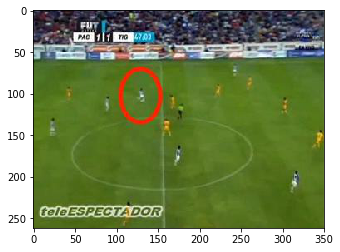

In [0]:
# Show original picture
img = random.choice(os.listdir('/content/drive/My Drive/testset'))
print(img)
img_path = '/content/drive/My Drive/testdata/' + img

with Image.open(img_path) as image:
    plt.imshow(image)

In [0]:
array = []
percent = []
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # move the model to cuda
    cuda = torch.cuda.is_available()
    if cuda:
        # Move model parameters to the GPU
        model.cuda()
        print("Number of GPUs:", torch.cuda.device_count())
        print("Device name:", torch.cuda.get_device_name(torch.cuda.device_count()-1))
    else:
        model.cpu()
        print("We go for CPU")
    
    # turn off dropout
    model.eval()

    # The image
    image = process_image(image_path)
    
    # tranfer to tensor
    image = torch.from_numpy(np.array([image])).float()
    
    # The image becomes the input
    image = Variable(image)
    if cuda:
        image = image.cuda()
        
    output = model.forward(image)
    
    probabilities = torch.exp(output).data
    
    # getting the topk (=5) probabilites and indexes
    # 0 -> probabilities
    # 1 -> index
    #print("no", probabilities)
    prob = torch.topk(probabilities, topk)[0].tolist()[0]
    #print("hello",prob)# probabilities
    for pr in prob:
      if(pr > 0.7):
        #print("uma",pr)
        percent.append(pr)
    index = torch.topk(probabilities, topk)[1].tolist()[0]
    
    #print(index[0])
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])
    #print("hi",ind)
    # transfer index to label
    label = []
    for i in range(4):
        label.append(ind[index[i]])
    #print("yes",label[0])
    percent.append(label[0])
    #print(percent, array)
    #print("hello",percent)
    return prob, label

Number of GPUs: 1
Device name: Tesla K80
[0.5080891251564026, 0.23772591352462769, 0.16904348134994507, 0.0550491139292717, 0.0225128885358572]
['3 Riot', '2 Demonstration', '5 Shoppers', '0 Parade']


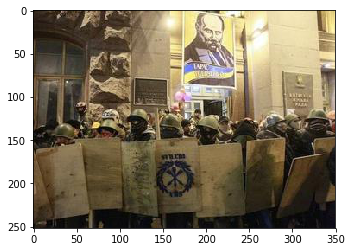

In [0]:
img = random.choice(os.listdir('/content/drive/My Drive/testdata'))
img_path = '/content/drive/My Drive/test/' + img
with  Image.open(img_path) as image:
    plt.imshow(image)
    
prob, classes = predict(img_path, model)
print(prob)
print(classes)
#print([hello[x] for x in classes])

In [0]:
import cv2
final = []
final1 = []
default_path = '/content/drive/My Drive/testset'
for x in os.listdir(default_path):
    #loc = 0
    if x.endswith(".jpg"):
        file=x
        image = cv2.imread(default_path + '/' + file)
        print(file)
        final1.append(file)
        img_path = '/content/drive/My Drive/test/' + file
        prob, classes = predict(img_path, model)
        #final.append(prob[0])
        #final1.append(classes[0])
        
        #print(prob[0],classes[0])
        hello = (prob[0], classes[0])
        print(hello)
        final.append(hello)
        #print(classes)

cheer7.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.42523226141929626, '4 Cheering')
cheer8.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.8596680760383606, '4 Cheering')
cheer9.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.8561573624610901, '4 Cheering')
cheer6.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.45589643716812134, '1 Handshaking')
cheer20.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.8891563415527344, '4 Cheering')
cheer4.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.5228102803230286, '4 Cheering')
cheer5.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.9893397688865662, '4 Cheering')
cheer2.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.8014180064201355, '4 Cheering')
cheer3.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.7375612258911133, '0 Parade')
cheer19.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.3568491041660309, '1 Handshaking')
cheer18.jpg
Number of GPUs: 1
Device name: Tesla K80
(0.9892398118972778, '4 Cheering')
cheer16.jpg
Number of GPUs: 1
Devi

In [0]:
import pandas as pd
import numpy as np
b = pd.DataFrame(final)

In [0]:
a = pd.DataFrame(final1)

In [0]:
print(b)

            0                1
0    0.425232       4 Cheering
1    0.859668       4 Cheering
2    0.856157       4 Cheering
3    0.455896    1 Handshaking
4    0.889156       4 Cheering
5    0.522810       4 Cheering
6    0.989340       4 Cheering
7    0.801418       4 Cheering
8    0.737561         0 Parade
9    0.356849    1 Handshaking
10   0.989240       4 Cheering
11   0.755256       4 Cheering
12   0.561492       4 Cheering
13   0.518487       4 Cheering
14   0.564497       4 Cheering
15   0.911709           3 Riot
16   0.717620         0 Parade
17   0.825938       4 Cheering
18   0.734863    1 Handshaking
19   0.596555       4 Cheering
20   0.964650    1 Handshaking
21   0.995795    1 Handshaking
22   0.736813           3 Riot
23   0.292352  2 Demonstration
24   0.953425    1 Handshaking
25   0.857966    1 Handshaking
26   0.775319       5 Shoppers
27   0.966367    1 Handshaking
28   0.740952           3 Riot
29   0.283134           3 Riot
..        ...              ...
110  0.6

In [0]:
print(a)

               0
0     cheer7.jpg
1     cheer8.jpg
2     cheer9.jpg
3     cheer6.jpg
4    cheer20.jpg
5     cheer4.jpg
6     cheer5.jpg
7     cheer2.jpg
8     cheer3.jpg
9    cheer19.jpg
10   cheer18.jpg
11   cheer16.jpg
12   cheer17.jpg
13   cheer10.jpg
14   cheer12.jpg
15   cheer13.jpg
16   cheer14.jpg
17   cheer15.jpg
18   cheer11.jpg
19    cheer1.jpg
20      hs12.jpg
21      hs10.jpg
22      hs13.jpg
23      hs14.jpg
24      hs15.jpg
25      hs18.jpg
26      hs11.jpg
27       hs1.jpg
28     demo8.jpg
29     demo9.jpg
..           ...
110     sh19.jpg
111     sh18.jpg
112     sh15.jpg
113     sh16.jpg
114     sh17.jpg
115     sh10.jpg
116     sh12.jpg
117     sh13.jpg
118     sh14.jpg
119     sh11.jpg
120      sh1.jpg
121      sc8.jpg
122      sc9.jpg
123      sc6.jpg
124     sc20.jpg
125      sc3.jpg
126      sc5.jpg
127      sc7.jpg
128      sc2.jpg
129      sc4.jpg
130     sc19.jpg
131     sc10.jpg
132     sc16.jpg
133     sc13.jpg
134     sc15.jpg
135     sc18.jpg
136     sc17.j

In [0]:
predictions = pd.DataFrame(final,columns=['confidence', 'events']).to_csv('checkVGG19.csv')

In [0]:
images = pd.DataFrame(final1,columns=['img_name']).to_csv('checkVGG19Image.csv')